In [1]:
import pandas as pd
import numpy as np

In [2]:
def to_rank(ss):
    ss = np.argsort(np.argsort(ss))
    ss = ss/np.nanmax(ss)
    return ss

In [3]:
def to_tier(ss, k=10):
#    return ss # 不处理
#     # 把因子按大小分成k份
    digit_values = ss.dropna().values
    me = np.nanmedian(digit_values)
    tiers = []
    for i in range(0,k-1):
        t = 100/k*(i+1)
        x = np.percentile(digit_values,t)
        tiers.append(x)
        me = (k-1)/2
        def func(x):
            if np.isnan(x):
                return 0
            else:
                for i in range(len(tiers)):
                    if x< tiers[i]:
                        return i-me
                    return len(tiers)-me
    res = ss.apply(func)
    return res

In [4]:
def nandivide(a,b):
    b = b.apply(lambda x:np.nan if x==0 else x)
    r = a/b 
    return r.fillna(0)

results = pd.DataFrame()

for year in [2011,2012,2013,2014,2015,2016,2017]:
    data = pd.read_csv("/Users/jiayangdu/Desktop/PWC/Rating Analysis/report_{}1231.csv".format(year), index_col=0) #循环
    data['date'] = year # 用二维数据表达三维数据需要增加因子
    data.fillna(0, inplace=True) # 用0填非值

   # 1 Net Receivables
    data['Net Receivables'] = (data['NOTES_RCV']
                                +data['ACCT_RCV']
                                +data['OTH_RCV']
                                +data['DVD_RCV']
                                +data['INT_RCV']
                                -data['NOTES_PAYABLE']
                                -data['ACCT_PAYABLE']
                                -data['ADV_FROM_CUST'])
    # 2~4                   
    data['Current Assets'] = data['TOT_CUR_ASSETS']
    data['Total Assets'] = data['TOT_ASSETS']
    data['Current Liabilities'] = data['TOT_CUR_LIAB']

    # 5 Total Long Term Debt
    data['Total Long Term Debt'] = (data['LT_BORROW']
                                    +data['BONDS_PAYABLE']
                                    +data['LT_PAYABLE'])

    # 6 PP&E
    # data['PP&E'] = data['FIX_ASSETS']
    data['PP&E'] = (data['FIX_ASSETS']
                    +data['CONST_IN_PROG']
                    +data['INVEST_REAL_ESTATE']
                    +data['PROJ_MATL']
                    +data['OIL_AND_NATURAL_GAS_ASSETS']
                    +data['PRODUCTIVE_BIO_ASSETS'])

    # 7 Securities
    data['Securities'] = (data['FIN_ASSETS_AVAIL_FOR_SALE']
                                        +data['TRADABLE_FIN_ASSETS'])

    # 8~9
    data['Depreciation'] = data['DEPR_FA_COGA_DPBA']
    data['Cash Flows from Operations'] = data['NET_CASH_FLOWS_OPER_ACT']

    # 10,11
    data['Sales'] = data['TOT_OPER_REV']
    data['COGS'] = data['LESS_OPER_COST']

    # 12 SG&A Expense
    data['SG&A Expense'] = (data['LESS_SELLING_DIST_EXP']
                            +data['LESS_GERL_ADMIN_EXP'])

    # 13
    data['Income from Continuing Operations'] = data['OPER_PROFIT']

    # others
    data['ds'] = data['Net Receivables']/data['Sales']
    # data['ds'] = nandivide(data['Net Receivables'],data['Sales'])
    data['gm'] = nandivide((data['Sales']-data['COGS']),data['Sales'])
    data['aq'] = nandivide(data['Total Assets']-(data['Current Assets']+data['PP&E']+data['Securities']),data['Total Assets'])
    data['de'] = nandivide(data['Depreciation'],(data['PP&E']+data['Depreciation']))
    data['sg'] = nandivide(data['SG&A Expense'],data['Sales'])
    data['lv'] = nandivide((data['Current Liabilities']+data['Total Long Term Debt']),data['Total Assets'])
    data['TATA'] = to_tier(nandivide((data['Income from Continuing Operations']-data['Cash Flows from Operations']),
                    data['Total Assets']))
    data['XueIdx_1'] = to_tier(nandivide(
        (data['OPER_PROFIT']+data['LESS_FIN_EXP']+data['DEPR_FA_COGA_DPBA']+data['AMORT_INTANG_ASSETS']),data['TOT_LIAB']))
    data['XueIdx_3'] = to_tier(nandivide(
        (data['TOT_PROFIT']- data['OPER_PROFIT']),
        data['TOT_PROFIT'].apply(lambda x: np.nan if x<=0 else x)
        ))
    data['XueIdx_4'] = to_tier(nandivide((data['ACCT_RCV']+data['NOTES_RCV']+data['OTH_RCV']),data['TOT_CUR_ASSETS']))    
    data['LOSS'] = (data['TOT_PROFIT']-data['PLUS_NON_OPER_REV']+data['LESS_NON_OPER_EXP']).apply(
        lambda x: 1 if x<0 else 0)
    data['OTHREC'] = to_tier(nandivide(data['OTH_RCV'],data['TOT_ASSETS']))
    data['size'] = to_tier(data['TOT_ASSETS'].apply(float))
    data['equity'] = data['TOT_ASSETS']-data['TOT_LIAB']
    data['cfi'] = to_tier(nandivide(data['NET_CASH_FLOWS_INV_ACT'],data['NET_CASH_FLOWS_OPER_ACT'].apply(abs)))
    data['cff'] = to_tier(nandivide(data['NET_CASH_FLOWS_FNC_ACT'],data['NET_CASH_FLOWS_OPER_ACT'].apply(abs)))
    #data['lin1'] =to_tier(nandivide(data['OTHER_CASH_RECP_RAL_FNC_ACT'],data['TOT_ASSETS']))
    data['lin2'] =to_tier(nandivide(data['TOT_CUR_LIAB'],data['Cash Flows from Operations'].apply(abs)))
    # data['lin_1'] = to_tier(nandivide(data['Sales']-data['Cash Flows from Operations'],data['Sales']))
    #data['turnover'] = to_tier(nandivide(data['Sales'],data['INVENTORIES']))
    # data['lin_5'] = to_tier(nandivide(data['INVENTORIES'],data['TOT_ASSETS']),k=11)
    
    results = pd.concat([results,data],axis=0)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [5]:
## 跨时期
for year in [2012,2013,2014,2015,2016,2017]:
    idx1 = results['date'] == year
    idx2 = results['date'] == year - 1

    results.loc[idx1,'DSRI'] = results.loc[idx1,'ds']/results.loc[idx2,'ds']   
    results.loc[idx1,'GMI'] = to_tier(nandivide(results.loc[idx1,'gm'],results.loc[idx2,'gm']))
    results.loc[idx1,'AQI'] = to_tier(nandivide(results.loc[idx1,'aq'],results.loc[idx2,'aq']))
    results.loc[idx1,'SGI'] = to_tier(nandivide(results.loc[idx1,'Sales']-results.loc[idx2,'Sales'],results.loc[idx2,'Sales']))
    results.loc[idx1,'DEPI'] = to_tier(nandivide(results.loc[idx2,'de'],results.loc[idx1,'de']))
    results.loc[idx1,'SGAI'] = to_tier(nandivide(results.loc[idx1,'sg'],results.loc[idx2,'sg']))
    results.loc[idx1,'LVGI'] = to_tier(nandivide(results.loc[idx1,'lv'],results.loc[idx2,'lv']))

    results.loc[idx1,'ac_chg'] = (
        results.loc[idx1,'ACCT_RCV']+results.loc[idx1,'NOTES_RCV']) - (results.loc[idx2,'ACCT_RCV']+results.loc[idx2,'NOTES_RCV'])
    results.loc[idx1,'cash'] = results.loc[idx1,'MONETARY_CAP']-results.loc[idx2,'MONETARY_CAP']

    results.loc[idx1,'XueIdx_2'] = to_tier(nandivide(results.loc[idx1,'cash'],
                    results.loc[idx1,'NON_CUR_LIAB_DUE_WITHIN_1Y']+
                    results.loc[idx1,'ST_BORROW']+
                    results.loc[idx1,'OTH_PAYABLE']+
                    results.loc[idx1,'ACCT_PAYABLE']+
                    results.loc[idx1,'NOTES_PAYABLE']))
    results.loc[idx1,'CH_CS'] = to_tier(
        nandivide(results.loc[idx1,'OPER_PROFIT']-results.loc[idx1,'ac_chg'],results.loc[idx1,'TOT_OPER_REV']))                
    results.loc[idx1,'fcf'] = to_tier(
        nandivide(results.loc[idx1,'free_cash_flow'] - results.loc[idx2,'free_cash_flow'],
        results.loc[idx2,'free_cash_flow'].apply(abs)))

    results.loc[idx1,'lin3'] = to_tier(nandivide(results.loc[idx1,'STOT_CASH_INFLOWS_INV_ACT'],
                                results.loc[idx2,'STOT_CASH_INFLOWS_INV_ACT']))
    results.loc[idx1,'lin4'] = to_tier(nandivide(results.loc[idx1,'OPER_PROFIT'],results.loc[idx2,'OPER_PROFIT']))

results.fillna(0)

,ACCT_PAYABLE,ACCT_RCV,ADV_FROM_CUST,AMORT_INTANG_ASSETS,BONDS_PAYABLE,COGS,CONST_IN_PROG,Cash Flows from Operations,Current Assets,Current Liabilities,...,DEPI,SGAI,LVGI,ac_chg,cash,XueIdx_2,CH_CS,fcf,lin3,lin4
3v3885096A,8.154011e+08,1.338770e+09,3.970765e+05,1723608.89,0.000000e+00,2.933685e+09,1.331976e+07,-4.750319e+08,2.098287e+09,1.400437e+09,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0
2AF3E846BD,3.156466e+08,5.006778e+08,2.799250e+08,3303442.90,0.000000e+00,5.050315e+09,2.664925e+08,-2.898325e+08,4.362397e+09,4.793211e+09,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0
3bIlRLVgWa,1.013818e+09,1.072916e+09,3.220861e+06,23585342.61,0.000000e+00,2.932598e+09,4.962262e+08,1.156984e+08,3.325999e+09,3.993981e+09,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0
2oH4EBB82B,1.905577e+08,1.149556e+08,3.124819e+07,3380017.58,1.992751e+08,7.098548e+08,7.171124e+07,6.855444e+07,7.894144e+08,9.302337e+08,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0
neOYOYVt6D,5.536253e+07,9.862195e+06,1.795888e+07,1587841.79,0.000000e+00,2.581093e+08,7.938336e+06,3.709066e+07,1.514165e+09,7.490338e+08,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2AF4DF7DDD,4.078390e+08,8.082232e+08,7.998753e+07,15512974.04,8.956964e+08,1.542067e+09,8.589708e+08,1.095332e+08,4.872380e+09,3.235466e+09,...,4.5,4.5,4.5,4.506037e+06,5.780043e+08,4.5,4.5,4.5,4.5,4.5
1AR3B54084,2.392252e+08,8.170224e+08,1.837297e+07,80307029.20,0.000000e+00,1.222978e+09,2.969054e+06,5.842347e+08,2.742830e+09,9.110021e+08,...,4.5,4.5,4.5,1.414956e+08,2.992841e+08,4.5,4.5,4.5,4.5,4.5
d47n41QHbj,5.739578e+09,1.659649e+09,1.578367e+09,41485138.34,6.305757e+09,4.309827e+10,3.584025e+09,-8.090482e+08,2.923645e+10,3.655558e+10,...,4.5,4.5,4.5,1.416832e+09,2.164571e+09,4.5,4.5,4.5,4.5,4.5
2NP032D265,6.299960e+08,4.821553e+07,3.682852e+08,1351723.38,1.300000e+10,2.193954e+09,1.137292e+10,1.807937e+09,4.039076e+10,9.965044e+09,...,4.5,4.5,4.5,-6.621488e+06,2.152419e+09,4.5,4.5,4.5,4.5,-4.5


In [ ]:
#results.to_csv('results.csv')

In [6]:
import pandas as pd

data = pd.read_csv('/Users/jiayangdu/Desktop/PWC/Rating Analysis/ratings.csv')
goodratings = ['AAA','Aa1','Aa2','AAA-','AA+','AA']
data = data.dropna(how='any')

# data['B_INFO_CREDITRATING2'] = [1 if x in goodratings else 0 for x in  data['B_INFO_CREDITRATING']]

data['B_INFO_CREDITRATING2'] = data['B_INFO_CREDITRATING'].apply(lambda x:
    1 if x in goodratings else 0)

data['B_INFO_PRECREDITRATING2'] = data['B_INFO_PRECREDITRATING'].apply(lambda x:
    1 if x in goodratings else 0)

data['label'] = data['B_INFO_PRECREDITRATING2'] - data['B_INFO_CREDITRATING2']

# ----------------------------

# data.loc[data['label'] == 1].to_csv('test.csv', encoding='GBK')

data_downgrade = data.loc[data['label'] == 1]
# data_downgrade.to_csv('data_downgrade.csv', encoding='GBK')

def func(company,date): # data里面 [company] 在这个日期 [之后一年]评级是否下调，下调返回1
    # date:2013 年报的年份
    x = data_downgrade.loc[
        data_downgrade['S_INFO_COMPCODE'] == company]
    if len(x)>0:
        # a:20130601 -> 2013 -> 2012年报信息
        x = x.loc[x['ANN_DT'].apply(lambda a: True if date+1 >= a//10000 > date else False)]
        if len(x) > 0:
            return 1
        return 0
    else:
        return 0

def func1(company,date): # data 里面选出[company]在这个日期[之前][最近的]评级是否为good，好公司返回true
    # data : 2012
    # ANN_DT: 20131201
    x = data.loc[data['S_INFO_COMPCODE']==company]
    if len(x)>0:
        x = x.loc[x['ANN_DT'].apply(lambda a: True if a//10000 <= date else False)]
        if len(x) > 0:
            x = x.sort_values(by='ANN_DT')
            return x.iloc[-1]['B_INFO_CREDITRATING'] in goodratings
        else:
            return False
    else:
        return False

# 示例数据
features_all = pd.DataFrame()
for year in [2012,2013,2014,2015,2016,2017]:
    tempdata = pd.read_csv('/Users/jiayangdu/Desktop/PWC/Rating Analysis/report_{}1231.csv'.format(year), index_col=0)
    tempdata['date'] = year
    # ...
    # tempdata['feature1'] = ...
    # ...
    features_all = pd.concat([features_all,tempdata], axis=0)


# 选出之前评级在2A以上的公司
print('step1')
features_all = features_all.loc[
    features_all.apply(lambda row: func1(row.name,row['date']), axis=1)]

# 把之前评级在2A以上，后续在2A以下的公司打1
print('step2')
features_all['label'] = features_all.apply(lambda row: func(row.name,row['date']), axis=1)

print('writing')
#features_all.to_csv('data_for_modeling_sample.csv')





step1
step2
writing


In [126]:
features_all

,LESS_FIN_EXP,LESS_GERL_ADMIN_EXP,LESS_NON_OPER_EXP,LESS_OPER_COST,LESS_SELLING_DIST_EXP,OPER_PROFIT,PLUS_NON_OPER_REV,TOT_OPER_REV,TOT_PROFIT,ACCT_PAYABLE,...,DEPR_FA_COGA_DPBA,NET_CASH_FLOWS_FNC_ACT,NET_CASH_FLOWS_INV_ACT,NET_CASH_FLOWS_OPER_ACT,OTHER_CASH_RECP_RAL_FNC_ACT,STOT_CASH_INFLOWS_INV_ACT,STOT_CASH_OUTFLOWS_INV_ACT,free_cash_flow,date,label
502042173,2.981022e+09,3.062211e+08,1.236317e+07,7.256330e+09,2.572778e+08,1.373809e+09,2.211910e+07,1.266473e+10,1.383564e+09,4.239628e+09,...,2.206024e+09,1.106681e+09,-6.882498e+09,4.891686e+09,5.496540e+08,1.157935e+09,8.040433e+09,-4.482393e+07,2012,0
fgK8oZEcM3,2.389262e+07,2.224131e+07,1.232032e+06,1.001408e+09,4.284713e+05,-1.018967e+07,1.931408e+08,1.064455e+09,1.817191e+08,8.672286e+08,...,3.946598e+07,7.941576e+08,-5.132901e+08,2.619953e+08,8.000000e+06,5.445872e+07,5.677488e+08,-9.970863e+08,2012,0
502033471,4.664194e+09,2.744445e+09,5.417450e+08,1.484064e+11,1.967922e+09,-9.887499e+09,1.337182e+09,1.494788e+11,-9.092062e+09,4.883484e+09,...,6.140958e+09,2.042895e+10,-2.315309e+10,1.122352e+09,1.802900e+08,7.123290e+08,2.386542e+10,1.514198e+10,2012,0
06G7DBBE14,3.773117e+08,4.913960e+08,9.997363e+06,3.056689e+09,7.925000e+04,6.982062e+08,2.182728e+08,4.644559e+09,9.064816e+08,1.770287e+08,...,6.131919e+08,-6.061454e+08,-4.288811e+08,1.299068e+09,6.836000e+06,1.526075e+09,1.954956e+09,7.723837e+08,2012,0
600992,5.620350e+08,2.691057e+09,5.617335e+07,4.497491e+10,4.827712e+09,-4.147132e+08,1.213643e+09,5.382215e+10,7.427563e+08,9.651303e+09,...,9.939984e+08,5.414891e+08,-5.721982e+08,5.548161e+08,1.782688e+09,2.182691e+09,2.754889e+09,-4.021697e+08,2012,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
g0oUr9ECup,1.187037e+08,1.848231e+08,3.936794e+06,3.919779e+09,2.251546e+07,-1.292400e+08,1.752430e+08,4.143591e+09,4.206625e+07,2.668164e+08,...,4.599625e+07,5.097938e+08,-7.566310e+08,2.008795e+08,7.940343e+08,2.139338e+08,9.705648e+08,-6.992451e+08,2017,0
2AF4DF7DDD,1.630394e+08,2.182468e+08,7.625440e+06,1.542067e+09,3.081142e+08,1.055497e+08,2.797460e+07,2.187317e+09,1.258988e+08,4.078390e+08,...,8.984882e+07,9.634149e+08,-6.732820e+08,1.095332e+08,9.338034e+07,1.222664e+09,1.895946e+09,-2.060447e+09,2017,0
d47n41QHbj,1.527294e+09,1.192460e+09,9.021290e+07,4.309827e+10,2.626439e+09,2.744008e+09,6.795363e+07,5.121297e+10,2.721749e+09,5.739578e+09,...,1.924509e+09,1.023322e+10,-8.040658e+09,-8.090482e+08,2.954057e+08,1.966639e+10,2.770705e+10,2.411807e+09,2017,0
2NP032D265,1.491362e+09,1.571301e+08,4.884532e+06,2.193954e+09,3.976591e+05,3.357128e+09,1.046511e+08,1.416134e+09,3.456894e+09,6.299960e+08,...,1.686825e+09,1.106349e+10,-1.071921e+10,1.807937e+09,NaN,8.219522e+08,1.154116e+10,2.401093e+08,2017,0


In [7]:
features_all.reset_index(inplace = True)

In [8]:
results.reset_index(inplace = True)

In [9]:
results.fillna(0,inplace=True)

In [10]:
features_all

,index,LESS_FIN_EXP,LESS_GERL_ADMIN_EXP,LESS_NON_OPER_EXP,LESS_OPER_COST,LESS_SELLING_DIST_EXP,OPER_PROFIT,PLUS_NON_OPER_REV,TOT_OPER_REV,TOT_PROFIT,...,DEPR_FA_COGA_DPBA,NET_CASH_FLOWS_FNC_ACT,NET_CASH_FLOWS_INV_ACT,NET_CASH_FLOWS_OPER_ACT,OTHER_CASH_RECP_RAL_FNC_ACT,STOT_CASH_INFLOWS_INV_ACT,STOT_CASH_OUTFLOWS_INV_ACT,free_cash_flow,date,label
0,502042173,2.981022e+09,3.062211e+08,1.236317e+07,7.256330e+09,2.572778e+08,1.373809e+09,2.211910e+07,1.266473e+10,1.383564e+09,...,2.206024e+09,1.106681e+09,-6.882498e+09,4.891686e+09,5.496540e+08,1.157935e+09,8.040433e+09,-4.482393e+07,2012,0
1,fgK8oZEcM3,2.389262e+07,2.224131e+07,1.232032e+06,1.001408e+09,4.284713e+05,-1.018967e+07,1.931408e+08,1.064455e+09,1.817191e+08,...,3.946598e+07,7.941576e+08,-5.132901e+08,2.619953e+08,8.000000e+06,5.445872e+07,5.677488e+08,-9.970863e+08,2012,0
2,502033471,4.664194e+09,2.744445e+09,5.417450e+08,1.484064e+11,1.967922e+09,-9.887499e+09,1.337182e+09,1.494788e+11,-9.092062e+09,...,6.140958e+09,2.042895e+10,-2.315309e+10,1.122352e+09,1.802900e+08,7.123290e+08,2.386542e+10,1.514198e+10,2012,0
3,06G7DBBE14,3.773117e+08,4.913960e+08,9.997363e+06,3.056689e+09,7.925000e+04,6.982062e+08,2.182728e+08,4.644559e+09,9.064816e+08,...,6.131919e+08,-6.061454e+08,-4.288811e+08,1.299068e+09,6.836000e+06,1.526075e+09,1.954956e+09,7.723837e+08,2012,0
4,600992,5.620350e+08,2.691057e+09,5.617335e+07,4.497491e+10,4.827712e+09,-4.147132e+08,1.213643e+09,5.382215e+10,7.427563e+08,...,9.939984e+08,5.414891e+08,-5.721982e+08,5.548161e+08,1.782688e+09,2.182691e+09,2.754889e+09,-4.021697e+08,2012,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13550,g0oUr9ECup,1.187037e+08,1.848231e+08,3.936794e+06,3.919779e+09,2.251546e+07,-1.292400e+08,1.752430e+08,4.143591e+09,4.206625e+07,...,4.599625e+07,5.097938e+08,-7.566310e+08,2.008795e+08,7.940343e+08,2.139338e+08,9.705648e+08,-6.992451e+08,2017,0
13551,2AF4DF7DDD,1.630394e+08,2.182468e+08,7.625440e+06,1.542067e+09,3.081142e+08,1.055497e+08,2.797460e+07,2.187317e+09,1.258988e+08,...,8.984882e+07,9.634149e+08,-6.732820e+08,1.095332e+08,9.338034e+07,1.222664e+09,1.895946e+09,-2.060447e+09,2017,0
13552,d47n41QHbj,1.527294e+09,1.192460e+09,9.021290e+07,4.309827e+10,2.626439e+09,2.744008e+09,6.795363e+07,5.121297e+10,2.721749e+09,...,1.924509e+09,1.023322e+10,-8.040658e+09,-8.090482e+08,2.954057e+08,1.966639e+10,2.770705e+10,2.411807e+09,2017,0
13553,2NP032D265,1.491362e+09,1.571301e+08,4.884532e+06,2.193954e+09,3.976591e+05,3.357128e+09,1.046511e+08,1.416134e+09,3.456894e+09,...,1.686825e+09,1.106349e+10,-1.071921e+10,1.807937e+09,NaN,8.219522e+08,1.154116e+10,2.401093e+08,2017,0


In [11]:
results

,index,ACCT_PAYABLE,ACCT_RCV,ADV_FROM_CUST,AMORT_INTANG_ASSETS,BONDS_PAYABLE,COGS,CONST_IN_PROG,Cash Flows from Operations,Current Assets,...,DEPI,SGAI,LVGI,ac_chg,cash,XueIdx_2,CH_CS,fcf,lin3,lin4
0,3v3885096A,8.154011e+08,1.338770e+09,3.970765e+05,1723608.89,0.000000e+00,2.933685e+09,1.331976e+07,-4.750319e+08,2.098287e+09,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0
1,2AF3E846BD,3.156466e+08,5.006778e+08,2.799250e+08,3303442.90,0.000000e+00,5.050315e+09,2.664925e+08,-2.898325e+08,4.362397e+09,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0
2,3bIlRLVgWa,1.013818e+09,1.072916e+09,3.220861e+06,23585342.61,0.000000e+00,2.932598e+09,4.962262e+08,1.156984e+08,3.325999e+09,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0
3,2oH4EBB82B,1.905577e+08,1.149556e+08,3.124819e+07,3380017.58,1.992751e+08,7.098548e+08,7.171124e+07,6.855444e+07,7.894144e+08,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0
4,neOYOYVt6D,5.536253e+07,9.862195e+06,1.795888e+07,1587841.79,0.000000e+00,2.581093e+08,7.938336e+06,3.709066e+07,1.514165e+09,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36732,2AF4DF7DDD,4.078390e+08,8.082232e+08,7.998753e+07,15512974.04,8.956964e+08,1.542067e+09,8.589708e+08,1.095332e+08,4.872380e+09,...,4.5,4.5,4.5,4.506037e+06,5.780043e+08,4.5,4.5,4.5,4.5,4.5
36733,1AR3B54084,2.392252e+08,8.170224e+08,1.837297e+07,80307029.20,0.000000e+00,1.222978e+09,2.969054e+06,5.842347e+08,2.742830e+09,...,4.5,4.5,4.5,1.414956e+08,2.992841e+08,4.5,4.5,4.5,4.5,4.5
36734,d47n41QHbj,5.739578e+09,1.659649e+09,1.578367e+09,41485138.34,6.305757e+09,4.309827e+10,3.584025e+09,-8.090482e+08,2.923645e+10,...,4.5,4.5,4.5,1.416832e+09,2.164571e+09,4.5,4.5,4.5,4.5,4.5
36735,2NP032D265,6.299960e+08,4.821553e+07,3.682852e+08,1351723.38,1.300000e+10,2.193954e+09,1.137292e+10,1.807937e+09,4.039076e+10,...,4.5,4.5,4.5,-6.621488e+06,2.152419e+09,4.5,4.5,4.5,4.5,-4.5


In [12]:
model = pd.merge(features_all,results, on=['index'], how='left')

In [14]:
model

,index,LESS_FIN_EXP_x,LESS_GERL_ADMIN_EXP_x,LESS_NON_OPER_EXP_x,LESS_OPER_COST_x,LESS_SELLING_DIST_EXP_x,OPER_PROFIT_x,PLUS_NON_OPER_REV_x,TOT_OPER_REV_x,TOT_PROFIT_x,...,DEPI,SGAI,LVGI,ac_chg,cash,XueIdx_2,CH_CS,fcf,lin3,lin4
0,502042173,2.981022e+09,3.062211e+08,12363173.77,7.256330e+09,2.572778e+08,1.373809e+09,22119095.68,1.266473e+10,1.383564e+09,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0
1,502042173,2.981022e+09,3.062211e+08,12363173.77,7.256330e+09,2.572778e+08,1.373809e+09,22119095.68,1.266473e+10,1.383564e+09,...,4.5,4.5,4.5,1.435914e+07,-8.820528e+08,4.5,4.5,4.5,4.5,4.5
2,502042173,2.981022e+09,3.062211e+08,12363173.77,7.256330e+09,2.572778e+08,1.373809e+09,22119095.68,1.266473e+10,1.383564e+09,...,4.5,4.5,4.5,-6.414358e+07,-3.545153e+08,4.5,4.5,4.5,4.5,4.5
3,502042173,2.981022e+09,3.062211e+08,12363173.77,7.256330e+09,2.572778e+08,1.373809e+09,22119095.68,1.266473e+10,1.383564e+09,...,4.5,4.5,4.5,2.269257e+08,-4.506900e+08,4.5,4.5,4.5,4.5,4.5
4,502042173,2.981022e+09,3.062211e+08,12363173.77,7.256330e+09,2.572778e+08,1.373809e+09,22119095.68,1.266473e+10,1.383564e+09,...,4.5,4.5,4.5,1.687758e+09,4.136956e+09,4.5,4.5,4.5,4.5,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91827,676193316,7.309638e+05,2.738460e+07,40.54,2.436089e+08,NaN,3.557247e+07,NaN,2.654532e+08,3.557243e+07,...,4.5,4.5,4.5,-8.035814e+05,-7.827261e+06,4.5,4.5,4.5,4.5,-4.5
91828,676193316,7.309638e+05,2.738460e+07,40.54,2.436089e+08,NaN,3.557247e+07,NaN,2.654532e+08,3.557243e+07,...,4.5,4.5,4.5,3.236474e+06,1.423527e+08,4.5,4.5,4.5,4.5,-4.5
91829,676193316,7.309638e+05,2.738460e+07,40.54,2.436089e+08,NaN,3.557247e+07,NaN,2.654532e+08,3.557243e+07,...,4.5,4.5,4.5,-3.835766e+06,7.908148e+07,4.5,4.5,4.5,4.5,4.5
91830,676193316,7.309638e+05,2.738460e+07,40.54,2.436089e+08,NaN,3.557247e+07,NaN,2.654532e+08,3.557243e+07,...,4.5,4.5,4.5,1.122546e+06,4.914771e+08,4.5,-4.5,4.5,4.5,-4.5


In [135]:
#model = pd.concat([results,features_all],axis=0)

In [117]:
#model.to_csv('data_for_modeling_sample.csv')

In [28]:
#import pandas as pd
#data = pd.read_csv('/Users/jiayangdu/Desktop/PWC/data_for_modeling_sample.csv',index_col=0)

In [31]:
#data['AQI1'] = pd.cut(data['AQI'], bins=10, labels=False)

In [34]:
#data['DSRI1'] = pd.cut(data['DSRI'], bins=10, labels=False)

In [37]:
#data['GMI1'] = pd.cut(data['GMI'], bins=10, labels=False)
#data['LVGI1'] = pd.cut(data['LVGI'], bins=10, labels=False)
#data['SGAI1'] = pd.cut(data['SGAI'], bins=10, labels=False)
#data['SGI1'] = pd.cut(data['SGI'], bins=10, labels=False)
#data['TATA1'] = pd.cut(data['TATA'], bins=10, labels=False)

In [154]:
reg_cols = [
    #    'intercept',
#         'GMI',        
        'SGI',
        'DEPI',
        'LVGI',
        'TATA',
        'XueIdx_1',
        'XueIdx_4',
        'LOSS',
        'CH_CS',
        'size',
       # 'lin_1',
       # 'lin1',
        'lin2',
        'lin3',
      #  'turnover'
        ]

x = model[reg_cols]
#y = x.corr()

In [155]:
import statsmodels.api as sm

In [156]:
logit = sm.Logit(model['label'], model[reg_cols])
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.061066
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                91832
Model:                          Logit   Df Residuals:                    91821
Method:                           MLE   Df Model:                           10
Date:                Wed, 08 Jul 2020   Pseudo R-squ.:                -0.04968
Time:                        11:07:38   Log-Likelihood:                -5607.8
converged:                       True   LL-Null:                       -5342.4
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SGI           -0.0802      0.010     -8.217      0.000      -0.099      -0.061
DEPI          -0.4250      0.

In [ ]:
reg_cols =model[['SGI',
        'DEPI',
        'LVGI',
        'TATA',
        'XueIdx_1',
        'XueIdx_4',
        'LOSS',
        'size',
       # 'lin_1',
       # 'lin1',
        'lin3']]

#y = model['label']

In [158]:
pred = result.predict(model[reg_cols]) 

In [159]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc  ###计算roc和auc

def illus_roc_curve(real,pred):
    # Compute ROC curve and ROC area for each class 
    
    fpr,tpr,threshold = roc_curve(real, pred) ###计算真正率和假正率
    roc_auc = auc(fpr,tpr) ###计算auc的值
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

In [161]:
real = model['label']

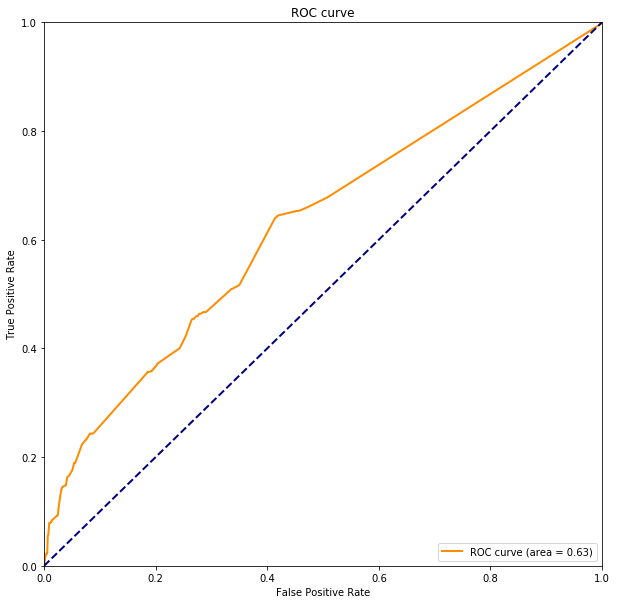

In [162]:
illus_roc_curve(real,pred)

In [164]:
import pandas as pd

def confusion_matrix(pred,real):
    x = pd.DataFrame()
    x['label'] = real
    x['predict'] = pred

    TruePositive = sum(x[x['predict']==1]['label']) #取预测为1的，并且真实为1的样本数量总和
    FalsePositive = sum(1-x[x['predict']==1]['label'])
    TrueNegative = sum(1-x[x['predict']==0]['label'])
    FalseNegative = sum(x[x['predict']==0]['label'])

    Precision = TruePositive/(TruePositive+FalsePositive)
    Recall = TruePositive/(TruePositive+FalseNegative)
    print('Precision: {}'.format(Precision))
    print('Recall: {}'.format(Recall))
    _confusion_matrix = pd.DataFrame({
                    'Negative':{'True':FalseNegative,'False':TrueNegative},
                    'Positive':{'True':TruePositive,'False':FalsePositive}                            
                    })        
    print(_confusion_matrix)
    return _confusion_matrix

In [165]:
pred = result.predict(model[reg_cols])
for t in [1e-5,1e-4,1e-3,1e-2]:
    print(t)
    pred2 = pred.apply(lambda x: 1 if x>t else 0)
    real = model['label']
    confusion_matrix(pred2,real)

1e-05
Precision: 0.010475651189127973
Recall: 1.0
       Negative  Positive
True          0       962
False         0     90870
0.0001
Precision: 0.010475651189127973
Recall: 1.0
       Negative  Positive
True          0       962
False         0     90870
0.001
Precision: 0.010480330315608284
Recall: 1.0
       Negative  Positive
True          0       962
False        41     90829
0.01
Precision: 0.017008864307902112
Recall: 0.46673596673596673
       Negative  Positive
True        513       449
False     64921     25949


In [146]:
#x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=1000)

In [147]:
#from sklearn.linear_model import LogisticRegression
#logmodel=LogisticRegression()
#logmodel.fit(x_train,y_train )

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [151]:
#predictions=logmodel.predict(x_test)

In [152]:
#from sklearn.metrics import classification_report,confusion_matrix

In [153]:
#print(classification_report(y_test,predictions))
#print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     27280
           1       0.00      0.00      0.00       270

    accuracy                           0.99     27550
   macro avg       0.50      0.50      0.50     27550
weighted avg       0.98      0.99      0.99     27550

[[27280     0]
 [  270     0]]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
